# Symbolic regression monobjective for slow solar wind

#### 1. Libraries importation

In [1]:
import math
from tqdm import tqdm
import random
import csv
import datetime
import time
import numpy
import operator
import matplotlib.pyplot as plt
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import pandas as pd
from deap import algorithms, base, creator , tools, gp
from sympy import sympify, sin, cos, simplify
import operations
import evaluators

#### 2. CSV importation

In [2]:
slow_wind = pd.read_csv(r'C:\Users\Christian Mariscal\Documents\TFM\venv_TFM\gp_data\slow_model_io.csv', delimiter = ',')
forecast = slow_wind['forecast']
slow_wind = slow_wind.drop(['Unnamed: 0', 'forecast'], axis = 1)

#### 3. Defining primitive set

In [3]:
#Second argument = number of variables in problem (this case, 56 vars)
pset = gp.PrimitiveSet("MAIN", 56)
#Second argument = arity
pset.addPrimitive(operations.add, 2)
pset.addPrimitive(operations.sub, 2)
pset.addPrimitive(operations.mul, 2)
pset.addPrimitive(operations.protectedDiv, 2)
pset.addPrimitive(operations.cos, 1)
pset.addPrimitive(operations.sin, 1)
pset.addPrimitive(operations.tan, 1)
pset.addPrimitive(operations.asin, 1)
pset.addPrimitive(operations.acos, 1)
pset.addPrimitive(operations.atan, 1)
pset.addPrimitive(operations.log10, 1)
pset.addPrimitive(operations.log, 1)
pset.addPrimitive(operations.sqrt, 1)
pset.addPrimitive(operations.exp, 1)
pset.addPrimitive(operations.pow, 2)

pset.addEphemeralConstant("rand101", lambda: random.randint(-1000,1000))
pset.addEphemeralConstant("pi", lambda: math.pi)
pset.addEphemeralConstant("e", lambda: math.e)

#Renaming arguments
renArg = dict(zip(pset.arguments, list(slow_wind.columns)))
pset.renameArguments(**renArg)

#### 4. Functions definition

In [4]:
def avgAbsError(individual, dataframe, forecast):
    
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    
    # Evaluate the mean squared error between the expression and the real function
    AvgAbsError = [abs(func(*dataframe.iloc[nrow]) - forecast[nrow]) for nrow in random.sample(range(len(dataframe)), int(len(dataframe)/2))]

    return sum(AvgAbsError) / len(AvgAbsError),

In [5]:
def EquationSimplifier(ind): 
    locals = {
        'sub': operations.sub,
        'protectedDiv': operations.protectedDiv,
        'mul': operations.mul,
        'add': operations.add,
        'pow': operations.pow
    }
    expr = sympify(ind , locals=locals)
    return expr

In [6]:
def StatsToCsv(StatsDF):
    replacement = [' ',':','.']
    date=datetime.datetime.now()
    for sign in replacement:
        date = str(date).replace(str(sign), '_') 
    StatsDF.to_csv(f'C:\Users\Christian Mariscal\Documents\TFM\\venv_TFM\Stats\MonoStats\slow\Stats{date}.csv')

In [7]:
def sizeAvgMax(stats): 
    fig, ax1 = plt.figure(), plt.axes()
    ax1.plot(stats['size_avg'], color = 'g', linestyle = '-', label = 'size_avg')
    ax1.plot(stats['size_max'], color = 'r', linestyle = '-', label = 'size_max')
    ax1.set_ylabel('Number of nodes')
    ax1.set_xlabel('Generations')
    ax1.set_title('Size evolution')
    plt.legend()
    plt.savefig(r'C:\Users\Christian Mariscal\Documents\TFM\venv_TFM\results\slow\mono\graphs\sizeAvgMax.png', facecolor='white')
    plt.show()

In [8]:
def depthMaxAvg(stats, heightLimit = None):
    fig, ax1 = plt.figure(), plt.axes()
    ax1.plot(stats['height_max'], color = 'r', linestyle = '-', label = 'depth_max')
    ax1.plot(stats['height_avg'], color = 'g', linestyle = '-', label = 'depth_avg')
    ax1.plot([heightLimit for i in range(len(stats))], color = 'y', linestyle = '-', linewidth = 3, label = 'Depth limit')
    ax1.set_ylabel('Tree depth')
    ax1.set_xlabel('Generations')
    ax1.set_title('Tree depth evolution')
    plt.legend()
    plt.savefig(r'C:\Users\Christian Mariscal\Documents\TFM\venv_TFM\results\slow\mono\graphs\depthMaxAvg.png', facecolor='white')
    plt.show()

In [9]:
def plotErrorDist(equation, pset, baseline, data, forecast):
    '''
    Distribution plot of an individual's errors. 
    
    :param equation(str): Equation based on pset.context operations
    :param pset(deap.gp.PrimitiveSet): Primitive set
    :param baseline(float): Algorithm baseline.
    :param data: Pandas dataframe containing solar wind data
    :param forecast: Pandas dataframe containing forecast to compare to.
    
    '''
    replacement = [' ',':','.']
    date=datetime.datetime.now()
    date = time.time()
    for sign in replacement:
        date = str(date).replace(str(sign), '_') 
    
    func = gp.compile(expr = equation, pset = pset)
    predicted = [func(*data.iloc[i]) for i in range(len(data))]
    forec = [forecast.iloc[i] for i in range(len(data))]
    errors = [abs(i-j) for i,j in zip(predicted, forec)]
    errors = pd.DataFrame(errors, columns=['errors'])
    bad_error = errors.loc[errors['errors']>baseline]
    good_error = errors.loc[errors['errors']<baseline]
    plt.hist(bad_error, color = 'r', label = f'Error > baseline: {len(bad_error)}', bins= int((bad_error.max()-bad_error.min())/5))
    plt.hist(good_error, color = 'g', label = f'Error < baseline: {len(good_error)}', bins= int((good_error.max()-good_error.min())/5))
    plt.legend()
    plt.title('Distribution plot of errors')
    plt.ylabel('Frequency')
    plt.xlabel('Average absolute error')
    plt.savefig(r'C:\Users\Christian Mariscal\Documents\TFM\venv_TFM\results\slow\mono\graphs\errorDist.png', facecolor='white')
    plt.show()

In [10]:
def absErrMinAvg(stats): 
    fig, ax1 = plt.figure(), plt.axes()
    ax1.plot(stats['AAE_min'], color = 'g', linestyle = '-', label = 'Min abs err')
    #ax1.plot(stats['AAE_avg'], color = 'r', linestyle = '-', label = 'Avg abs err')
    ax1.set_ylabel('Absolute error')
    ax1.set_xlabel('Generations')
    ax1.set_title('Absolute error evolution')
    plt.legend()
    plt.savefig(r'C:\Users\Christian Mariscal\Documents\TFM\venv_TFM\results\slow\mono\graphs\absErrMinAvg.png', facecolor='white')
    plt.show()

In [11]:
def eaSimpleOr(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__, multiThread = False, multiProcess = False):

    print(f'--------Starting algorithm of {len(population)} individuals and {ngen} generations--------')
    start = time.time()
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    if multiThread == True: 
        print(f'---------Entering multithreading--------')
        with ThreadPoolExecutor() as executor:
            futures = []
            for ind in invalid_ind: 
                future = executor.submit(toolbox.evaluate, ind)
                futures.append(future)
            fitnesses = [future.result() for future in futures]
    elif multiProcess==True:
        print('--------Entering multiprocessing--------')
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    else: 
        print('--------Entering without accelerators activated--------')
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
         
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    if halloffame is not None:
        halloffame.update(population)
        hof_size = len(halloffame.items) 
    else: 
        hof_size=0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    # Begin the generational process
    for gen in tqdm(range(1, ngen + 1)):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population)-hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varOr(offspring, toolbox, len(population)-hof_size, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        
        if multiThread == True: 
            print(f'--------Entering generation {gen}--------')
            with ThreadPoolExecutor() as executor:
                futures = []
                for ind in invalid_ind: 
                    future = executor.submit(toolbox.evaluate, ind)
                    futures.append(future)
                fitnesses = [future.result() for future in futures]
        else: 
            print(f'--------Entering generation {gen}--------')
            fitnesses = list(toolbox.map(toolbox.evaluate, invalid_ind))
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            offspring.extend(halloffame.items)
            halloffame.update(offspring)
            fitnesses.extend(hof.fitness.values for hof in halloffame)
            
        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            StatisticsDataFrame = (logbook.stream)
            
        bestMetric = min([king.fitness.values for king in hof.items])
        for king in hof.items: 
            if king.fitness.values == bestMetric: 
                emperor = king
                
        print(f"Best individual fitness is: {bestMetric}")
        print(f'{popSize};{cxpb};{mtpb};{ngen};{maxHeight};{accelerator};{emperor.__str__()};{bestMetric};', file=open(r'C:\Users\Christian Mariscal\Documents\TFM\venv_TFM\results\slow\mono\genStats\results.txt', 'a'))

    end = time.time()
    
    print(f'--------Algorithm execution took {end - start} s--------')
    
    return population, logbook, halloffame, StatisticsDataFrame

#### 5. Parameters definition

In [12]:
#Defining fitness class
creator.create("FitnessMin", base.Fitness, weights=(-1,))

#Defining individuals shape and associating fitness attribute
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

#Creating toolbox to register: population creation, evaluation function, selection mecanism
#and genetic operators
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", avgAbsError, dataframe=slow_wind, forecast=forecast)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
maxHeight = 10
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=maxHeight))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=maxHeight))

#### 6. Algorithm initialization

In [13]:
if __name__ == "__main__": 
    
    random.seed(318)
    CPUs = None
    multiProcess = False
    multiThread = False
    
    print('------Let\'s select algorithm parameters------')
    popSize=int(input('Select number of individuals: '))
    pop = toolbox.population(n=popSize)
    cxpb = float(input('Select crossover probability: '))
    mtpb = float(input('Select mutation probability: '))
    ngen = int(input('Select number of generations: '))
    accelerator = int(input('Select accelerator: Multithreading(1), multiprocessing(2) or none(3): '))
    if accelerator == 1: 
        multiThread = True
    elif accelerator == 2:
        multiProcess = True
        CPUs = int(input(f'Select number of cpu\'s for multiprocessing (CPUs available = {multiprocessing.cpu_count()}): '))
        pool = multiprocessing.Pool(CPUs)
        toolbox.register("map", pool.map)
        
    hof = tools.HallOfFame(3)
    stats_fit_AAE = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    stats_height = tools.Statistics(lambda ind: ind.height)
    mstats = tools.MultiStatistics(AAE=stats_fit_AAE, size=stats_size, height=stats_height)
    mstats.register("avg", numpy.mean)
    mstats.register("std", numpy.std)
    mstats.register("min", numpy.min)
    mstats.register("max", numpy.max)
    
    pop, log, hof, StatisticsDataFrame = eaSimpleOr(pop, toolbox, cxpb, mtpb, ngen, stats=mstats, halloffame=hof, verbose=True, multiProcess = multiProcess, multiThread = multiThread)
    
    #Compute best individual metrics
    bestMetric = min([king.fitness.values for king in hof.items])
    print(f"Metric of best individual is: {bestMetric}")
    
    #Extracting simpler equation
    for king in hof.items: 
        if king.fitness.values == bestMetric: 
            emperor = king
    SimplerExpr = EquationSimplifier(emperor.__str__())
    print(f'--------Original equation--------: {emperor.__str__()}')
    print(f'--------Simplified equation--------: {SimplerExpr}')
    
    #Save stats to csv
    StatsToCsv(StatisticsDataFrame)

------Let's select algorithm parameters------
Select number of individuals: 10
Select crossover probability: .9
Select mutation probability: .1
Select number of generations: 10
Select accelerator: Multithreading(1), multiprocessing(2) or none(3): 1
--------Starting algorithm of 10 individuals and 10 generations--------
---------Entering multithreading--------


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

--------Entering generation 1--------


 10%|████████▎                                                                          | 1/10 [00:00<00:08,  1.07it/s]

Best individual fitness is: (69.28929945405747,)
--------Entering generation 2--------


 20%|████████████████▌                                                                  | 2/10 [00:02<00:08,  1.04s/it]

Best individual fitness is: (69.28929945405747,)
--------Entering generation 3--------


 30%|████████████████████████▉                                                          | 3/10 [00:03<00:08,  1.21s/it]

Best individual fitness is: (69.28929945405747,)
--------Entering generation 4--------


 40%|█████████████████████████████████▏                                                 | 4/10 [00:04<00:07,  1.27s/it]

Best individual fitness is: (67.69528369810034,)
--------Entering generation 5--------


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:06<00:06,  1.31s/it]

Best individual fitness is: (67.69528369810034,)
--------Entering generation 6--------


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:07<00:05,  1.33s/it]

Best individual fitness is: (67.69528369810034,)
--------Entering generation 7--------


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:08<00:03,  1.23s/it]

Best individual fitness is: (67.69528369810034,)
--------Entering generation 8--------


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:09<00:02,  1.16s/it]

Best individual fitness is: (67.69528369810034,)
--------Entering generation 9--------


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:10<00:01,  1.21s/it]

Best individual fitness is: (67.69528369810034,)
--------Entering generation 10--------


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.23s/it]

Best individual fitness is: (67.69528369810034,)
--------Algorithm execution took 14.130481719970703 s--------
Metric of best individual is: (67.69528369810034,)
--------Original equation--------: add(protectedDiv(Bx_1d_4, speed_carrington_2), speed_carrington_2)
--------Simplified equation--------: Bx_1d_4/speed_carrington_2 + speed_carrington_2


#### 7. Graphs

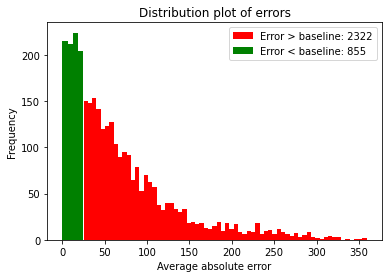

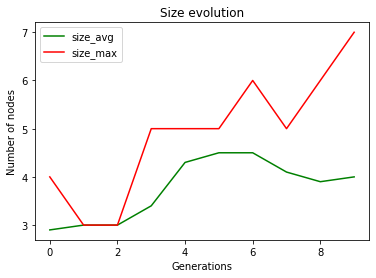

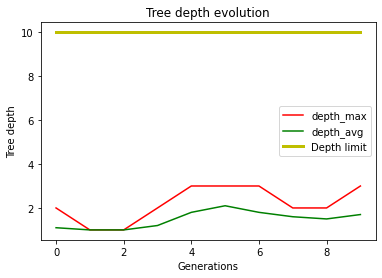

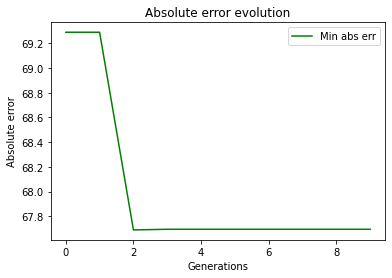

In [14]:
if __name__ == '__main__': 
    baseline = 24.92852089
    plotErrorDist(emperor.__str__(), pset, baseline, slow_wind, forecast)
    sizeAvgMax(StatisticsDataFrame)
    depthMaxAvg(StatisticsDataFrame, maxHeight)
    absErrMinAvg(StatisticsDataFrame)